In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from quad_utils import *
from other_utils import *


## Multivariate Mixture

Derived in Appendix A, we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$




$$
v_{\text{mix}}[k] = \sum_{j=1}^J w_j\, v_j[k],
$$

where:
$$
v[k] = \sigma_f^2 |\mathbf{L}| |\Sigma_p + \mathbf{L^2}|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p +  \mathbf{L^2})^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]
$$

and 
$$
vv_{\text{mix}}[k] = \sum_{i=1}^J \sum_{j=1}^J w_i w_j\, I_{ij},
$$


where:
$$
I_{ij}
= \sigma_f^2|\mathbf{L}| \big|\Sigma_i+\Sigma_j+\mathbf{L}^2\big|^{-1/2}
\exp\Big(-\tfrac{1}{2}(\boldsymbol\mu_i-\boldsymbol\mu_j)^T(\Sigma_i+\Sigma_j+\mathbf{L}^2)^{-1}(\boldsymbol\mu_i-\boldsymbol\mu_j)\Big).
$$

In [2]:
def mc_nd(func, mus, covs, weights=None, n=100_000):
    mus = jnp.atleast_2d(mus)
    covs = np.array([np.diag(c) for c in covs])
    n_components, d = mus.shape

    # default to equal weights
    if weights is None:
        weights = np.ones(n_components)/n_components
    else:
        weights = np.array(weights)/np.sum(weights)

    counts = np.random.multinomial(n, weights)
    samples = np.empty((n, d))
    start = 0
    for i, n_i in enumerate(counts):
        if n_i > 0:
            samples[start:start+n_i] = np.random.multivariate_normal(mus[i], covs[i], n_i)
            start += n_i

    # evaluate function
    values = func(*samples.T)
    mean_est = np.mean(values)
    se_est = np.std(values, ddof=1)/np.sqrt(n)

    return mean_est, se_est

## Multivariate Mixture

### Bivariate mixture


The following bivariate function is used:

$$
g(x, y) = \sin^2\left(0.4\sqrt{x^2 + xy + y^2}\right).
$$

The quadrature is performed with respect to a bivariate Gaussian mixture:

$$
\text{mean} =
\begin{bmatrix}
2 & 3 \\
-3 & -2 \\
-1 & 1
\end{bmatrix}, \quad
\text{cov} =
\begin{bmatrix}
1 & 3 \\
1 & 3 \\
1 & 1
\end{bmatrix}, \quad
\text{weights} =
\begin{bmatrix}
0.4 \\
0.2 \\
0.4
\end{bmatrix}
$$





Bivariate normal with mean: [[ 2.  3.]
 [-3. -2.]
 [-1.  1.]] and cov: [[1. 3.]
 [1. 3.]
 [1. 1.]]

MC estimate: 0.5595497050073881
MC stdev: 0.0004554828029491571
GP estimate: 0.5585713411193411
GP stdev: 0.002659095007130499


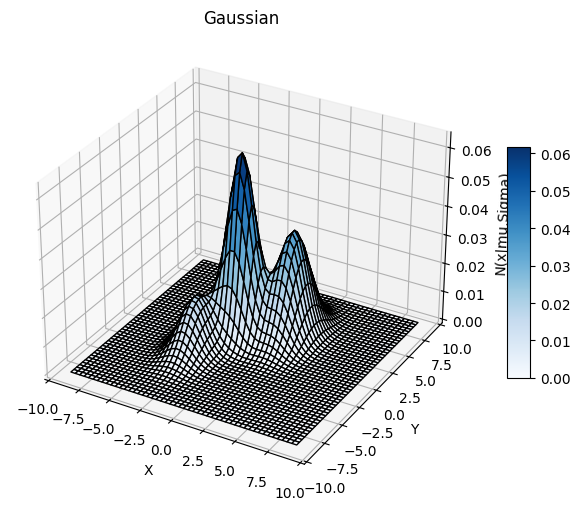

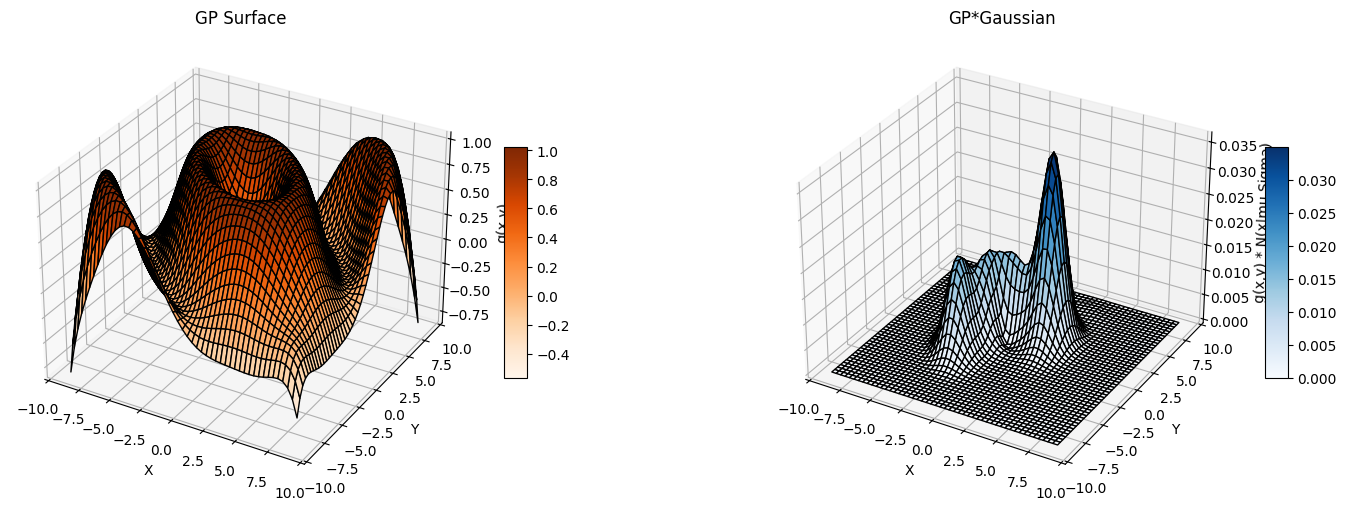

In [3]:
def g(x, y):
    r = 0.4*np.sqrt(x**2 + x*y + y**2)
    return np.sin(r)**2

# Define mixture parameters 
mean = jnp.array([[2, 3], [-3, -2], [-1.0, 1.0]])
cov = jnp.array([[1.0, 3.0], [1.0 ,3.0], [1.0, 1.0]])
weights = jnp.array([0.4, 0.2, 0.4])

# Monte Carlo estimation 
ev = mc_nd(g, mean, cov, n=500_000, weights= weights)
print(f"Bivariate normal with mean: {mean} and cov: {cov}\n")
print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


# Generate training data on a grid
x = np.linspace(-8, 8, 10)
y = np.linspace(-8, 8, 10)
X, Y = np.meshgrid(x, y)
xy = jnp.column_stack([X.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1])

# Hyperparameters for GP and mixture
params = mean, cov
s = 6
L = jnp.array([4,4])
m0 = jnp.array(2.)
x_m = jnp.array([0,0])
w = jnp.array([2,2])
sigma_e = 0.0
hp_sample = (jnp.array([s]), [L], m0, x_m, w, 0.0)

# Reshape data for GP integration
x1, y1 = reshape(xy, gxy1)

# Compute GP kernel matrices and inverses
chol_k1, kxx_inv = kinv(xy, hp_sample)
chol_k1 = chol_k1[0]
kxx_inv = kxx_inv[0]

hp_sample = (s, L, m0, x_m, w, sigma_e)
mu_int, var_int = integrate_mixture_n(
    x1, y1,
    m_params=(params[0], params[1]),
    hp_params=hp_sample,
    weights=weights,
    chol_k=chol_k1
)

print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


# Define evaluation points for plotting
x = np.linspace(-9, 9, 50)
y = np.linspace(-9, 9, 50)
X_eval, Y_eval = np.meshgrid(x, y)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])

# GP predictions at evaluation points
mu_grid, var_eval = gp_predict(
        x1, y1, xy_eval,
        s=s, L=jnp.diag(L),
        m0=m0, x_m=x_m, w=w,
        K_inv=kxx_inv
)
mu_grid = mu_grid.reshape(X_eval.shape)

# Compute Gaussian pdf at evaluation points
Sigma = jnp.array([jnp.diag(s) for s in cov])
pdf_vals = mixture_pdf(xy_eval, mean, Sigma, weights=weights)
pdf_grid = pdf_vals.reshape(X_eval.shape)

# Compute product of GP mean and Gaussian pdf for visualization
product_grid = mu_grid * pdf_grid


# Plot Gaussian mixture surface
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_eval, Y_eval, pdf_grid, cmap="Blues", edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('N(x|mu,Sigma)')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title('Gaussian')
plt.show()


# Plot GP surface and product surface side by side
fig = plt.figure(figsize=(18, 6))

# GP surface plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_eval, Y_eval, mu_grid, cmap="Oranges", edgecolor='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('g(x,y)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title('GP Surface')

# Product of GP and Gaussian plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X_eval, Y_eval, product_grid, cmap="Blues", edgecolor='k')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('g(x,y) * N(x|mu,Sigma)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title('GP*Gaussian')

plt.show()


### Trivariate Mixture

The following trivariate function is used:

$$
g(x, y, z) = \sin^2\Bigg( 3 \, \sqrt{x^2 + xy + xz + yz + y^2 + z^2} \Bigg)
$$

The quadrature is performed with respect to a trivariate Gaussian mixture:

$$
\text{mean} =
\begin{bmatrix}
1 & -2 & 1 \\
-1 & 0.4 & 1
\end{bmatrix}, \quad
\text{cov} =
\begin{bmatrix}
1.0 & 0.8 & 2.0 \\
0.1 & 2.0 & 2.0
\end{bmatrix}, \quad
\text{weights} =
\begin{bmatrix}
0.3 \\
0.7
\end{bmatrix}
$$


In [4]:
def g3(x, y, z):
    r = 0.3*np.sqrt(x**2 + x*y + x*z + y*z + y**2 + z**2)
    return np.sin(3*r)**2


# Define mixture parameters 
mean = jnp.array([[1, -2, 1], [-1, 0.4, 1]])
cov = jnp.array([[1.0, 0.8, 2.0], [0.1, 2.0 ,2.0]])
weights = jnp.array([0.3, 0.7])

# Monte Carlo estimation
ev = mc_nd(g3, mean, cov, n=500_000, weights=weights)


print(f"Trivariate normal with mean: {mean} and cov: {cov}")
print()
print("MC estimate:", ev[0])
print("MC stdev:", ev[1])
print()


# Generate training data on a 3D grid
x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
z = np.linspace(-5, 5, 11)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T)


# Hyperparameters for GP and mixture
params = mean, cov
s = 10
L = jnp.array([2,2,2])
m0 = jnp.array(2.)
x_m = jnp.array([0,0,0])
w = jnp.array([2,2,2])
sigma_e = 0.0
hp_sample = (jnp.array([s]), [L], m0, x_m, w, 0.0)


x, y = reshape(xyz, gxyz)
chol_k1, kxx_inv = kinv(xyz, hp_sample)
chol_k1 = chol_k1[0]
kxx_inv = kxx_inv[0]

hp_sample = (s, L, m0, x_m, w, sigma_e)
mu_int, var_int = integrate_mixture_n(
    x, y,
    m_params=(params[0], params[1]),
    hp_params=hp_sample,
    weights=weights,
    chol_k=chol_k1
)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


Trivariate normal with mean: [[ 1.  -2.   1. ]
 [-1.   0.4  1. ]] and cov: [[1.  0.8 2. ]
 [0.1 2.  2. ]]

MC estimate: 0.6511861118226547
MC stdev: 0.00045638359425279946

GP estimate: 0.6511655532111595
GP stdev: 0.0013808600272315883
